# Netflix Movie Dataset Analysis and Recommendation System

In this notebook, we will:
1. Download the Netflix movie dataset.
2. Perform exploratory data analysis (EDA).
3. Visualize data trends.
4. Draw deductions and insights.
5. Build a movie recommendation system using collaborative filtering.

Let's begin by downloading the dataset and installing the necessary libraries.


# Dataset Download


In [1]:
# Import KaggleHub to download Netflix dataset from Kaggle
import kagglehub

# Download the Netflix dataset
path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

print("Path to dataset files:", path)


100%|██████████| 683M/683M [00:06<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2


# Install Necessary Libraries

In [2]:
# Install Surprise library for collaborative filtering model
!pip install surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357269 sha256=d607d3f9006384ce44e05f113b4ccff8aaabfb05fb4da76ac25878ac1e6ecafc
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


# Import Libraries and Set Up

In [3]:
# Import necessary libraries for analysis and modeling
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Set seaborn style for better visualization
sns.set_style("darkgrid")


# Load and Explore Datasets

In [4]:
# Load Netflix datasets and explore their structure
df1 = pd.read_csv(f'{path}/combined_data_1.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1])
df1['Rating'] = df1['Rating'].astype(float)

# Display dataset shape and sample rows
print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

# Repeat for datasets 2, 3, and 4
df2 = pd.read_csv(f'{path}/combined_data_2.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
df3 = pd.read_csv(f'{path}/combined_data_3.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
df4 = pd.read_csv(f'{path}/combined_data_4.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])

# Convert ratings to float for consistency
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

# Print shapes of datasets for verification
print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))


Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0
Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


#  Combine Datasets


In [5]:
# Combine all the datasets into one dataframe
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Reset the index after concatenation
df.index = np.arange(0, len(df))

# Print combined dataset shape and examples
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])


Full dataset shape: (100498277, 2)
-Dataset examples-
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


# Exploratory Data Analysis (EDA) - Basic Overview
**Deductions:**

1.   Rating Distribution: The bar chart reveals that most ratings given by users are skewed toward higher values, indicating that users tend to give favorable ratings to movies.
2.   User Behavior: Customers tend to be less critical and more positive in rating movies, with fewer low ratings being given.



<ipython-input-6-53ceb0164c59>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = df.isnull().sum()[1]


<Figure size 1500x800 with 0 Axes>

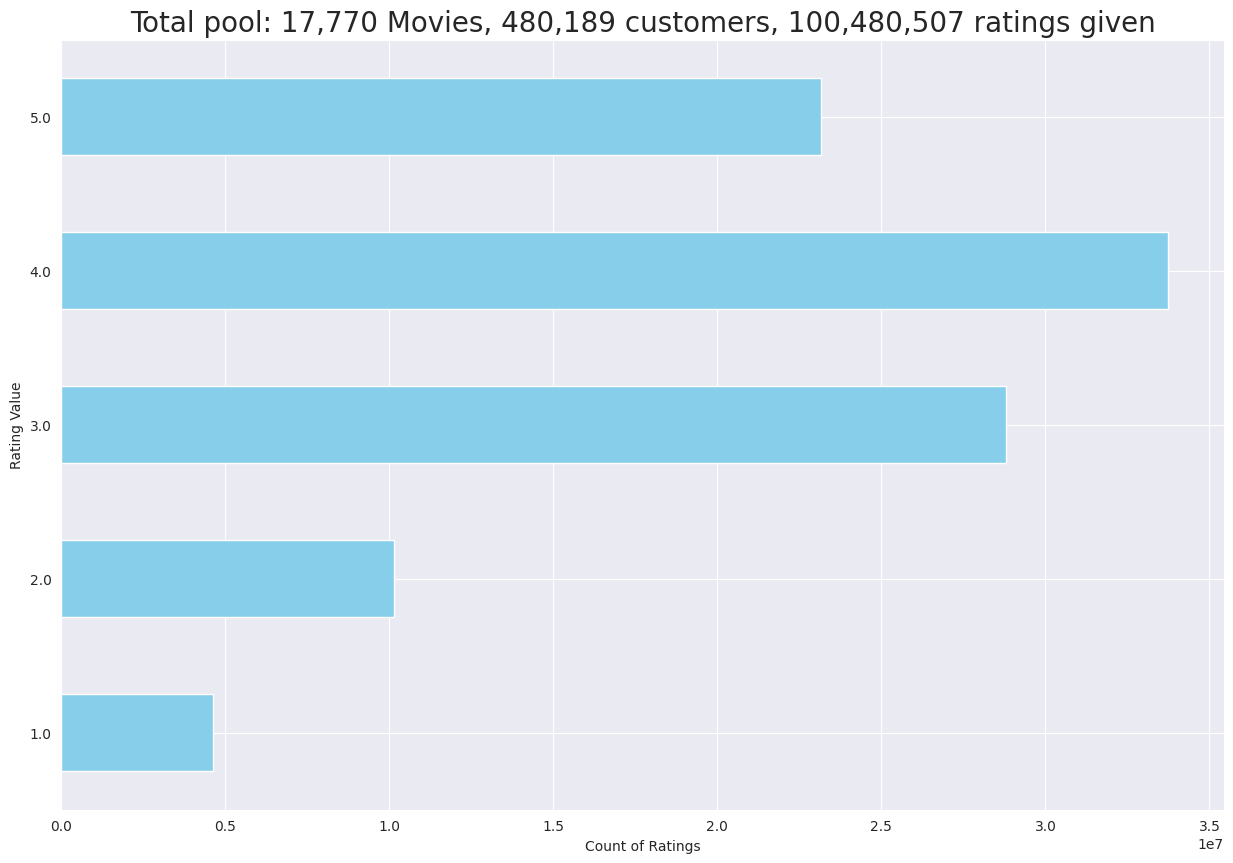

In [6]:
# EDA: Group by rating and count each rating occurrence
p = df.groupby('Rating')['Rating'].agg(['count'])

# Calculate movie count (rows with NaN values in Rating)
movie_count = df.isnull().sum()[1]

# Calculate customer count and rating count
cust_count = df['Cust_Id'].nunique() - movie_count
rating_count = df['Cust_Id'].count() - movie_count

# Visualize the distribution of ratings
plt.figure(figsize=(15, 8))
ax = p.plot(kind='barh', legend=False, figsize=(15,10), color='skyblue')
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.xlabel('Count of Ratings')
plt.ylabel('Rating Value')
plt.show()


# Handle Missing Data

In [ ]:
# Identify and handle rows with missing ratings (NaN values)
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True].reset_index()

# Generate movie IDs using numpy array to fill NaN spaces
movie_np = []
movie_id = 1

# Fill the gaps between movie IDs in the dataset
for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    temp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Fill for the last record
last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

# Remove NaN rows and assign movie IDs
df = df[pd.notnull(df['Rating'])]
df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

# Display dataset with movie IDs added
print('-Dataset examples-')
print(df.iloc[::5000000, :])


# Advanced EDA - Movie and Customer Statistics

In [ ]:
# Generate summary statistics for each movie and customer
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count', 'mean'])
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7), 0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count', 'mean'])
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7), 0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))


# Visualizing Movie Ratings Count
**Deductions:**

1. The histogram shows a right-skewed distribution where most movies receive fewer reviews, while a small number of popular movies attract many reviews. This highlights the significant disparity in movie popularity, a common pattern in recommendation systems.


In [ ]:
# Visualizing the distribution of movie rating counts
plt.figure(figsize=(15, 8))
sns.histplot(df_movie_summary['count'], bins=50, kde=False, color='blue')
plt.title('Distribution of Movie Rating Counts', fontsize=20)
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()


# Visualizing Customer Rating Counts
**Deductions:**


1.  Most users rate a limited number of movies, with only a few users rating a large number of movies. This implies that the majority of customers are casual raters, while a small fraction of power users rate more frequently.

In [ ]:
# Visualizing the distribution of customer rating counts
plt.figure(figsize=(15, 8))
sns.histplot(df_cust_summary['count'], bins=50, kde=False, color='green')
plt.title('Distribution of Customer Rating Counts', fontsize=20)
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()


# Trimming Dataset Based on Benchmarks

In [ ]:
# Trim the dataset by removing less frequently reviewed movies and customers
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))


# Create Pivot Table

In [ ]:
# Create a pivot table for movies and customer ratings
df_p = pd.pivot_table(df, values='Rating', index='Cust_Id', columns='Movie_Id')

# Display pivot table shape
print(df_p.shape)


# Load Movie Titles

In [ ]:
# Load movie titles dataset and set Movie_Id as index
df_title = pd.read_csv('../input/movie_titles.csv', encoding="ISO-8859-1", header=None, names=['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace=True)

# Display first 10 rows of movie titles
print(df_title.head(10))


# Collaborative Filtering - Matrix Factorization Using SVD


In [ ]:
# Using collaborative filtering to build a recommendation system
reader = Reader()

# Load dataset from DataFrame
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

# Use Singular Value Decomposition (SVD) model
svd = SVD()

# Perform cross-validation on the dataset
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


#  Movie Recommendation System

In [ ]:
# Build movie recommendation system based on user input and correlation
def recommend(movie_title, min_count):
    print("Top 10 recommended movies are:")

    # Filter based on minimum count of ratings
    movie_id = df_title.index[df_title['Name'] == movie_title][0]
    target_movie_ratings = df_p[movie_id]
    similar_to_target = df_p.corrwith(target_movie_ratings)

    corr_target = pd.DataFrame(similar_to_target, columns=['PearsonR'])
    corr_target.dropna(inplace=True)

    corr_summary = corr_target.join(df_movie_summary['count'])
    recommendations = corr_summary[corr_summary['count'] > min_count].sort_values('PearsonR', ascending=False).head(10)

    print(recommendations)

# Call the recommendation function for a sample movie
recommend("What the #$*! Do We Know!?", 100)
